In [211]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.distributions as D
from torch.distributions.transformed_distribution import TransformedDistribution
import torchvision
import torchvision.transforms as transforms
import math
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

#### Model Implementation

In [213]:
class NICE(nn.Module):
    # NICE model architecture 
    def __init__(self, in_feature, hidden_feature):
        super().__init__()
        
        # Affine Coupling layer         
        self.flow_block = nn.Sequential(
            nn.Linear(in_feature // 2, hidden_feature), 
            nn.ReLU(True),
            nn.Linear(hidden_feature, hidden_feature), 
            nn.ReLU(True),
            nn.Linear(hidden_feature, hidden_feature), 
            nn.ReLU(True),
            nn.Linear(hidden_feature, hidden_feature), 
            nn.ReLU(True),
            nn.Linear(hidden_feature, hidden_feature), 
            nn.ReLU(True),
            nn.Linear(hidden_feature, in_feature // 2),
            nn.ReLU(True)
        )
        
        # 4 layer architecture
        self.model = torch.nn.ModuleList([self.flow_block for block in range(4)])
        self.scaling = torch.nn.Parameter(torch.randn(in_feature))
        
    def splitting(self, data, layer):
        # Split data into two blocks (even and odd indices)
        if layer % 2 == 0:
            x1 = data[:, ::2]
            x2 = data[:, 1::2]
        else:
            x1 = data[:, 1::2]
            x2 = data[:, ::2]

        return x1, x2 
            
    def forward(self, x):
        for layer in range(len(self.model)):
            x1, x2 = self.splitting(x, layer)
            h1 = x1 
            h2 = x2 + self.model[layer](x1)
            x[:, ::2] = h1
            x[:, 1::2] = h2

        z = torch.exp(self.scaling) * x
        return z, torch.sum(self.scaling)
    
    def reverse(self, z):
        x = z * torch.exp(-self.scaling)
        for layer in range(len(self.model)-1,-1,-1):
            h1 = x[:, ::2]
            h2 = x[:, 1::2]
            x1 = h1
            x2 = h2 - self.model[layer](x1)
            if layer % 2 == 0:
                x[:, ::2] = x1
                x[:, 1::2] = x2
            else:
                x[:, 1::2] = x1
                x[:, ::2] = x2
            
        return x 

#### Training

In [214]:
model = NICE(784, 1000)

In [215]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data_size = 2000
data_idx =  torch.randperm(len(train_set))
data_idx = data_idx[:data_size]
sub_dataset = torch.utils.data.Subset(train_set, data_idx)
train_loader = torch.utils.data.DataLoader(sub_dataset, batch_size=64, shuffle=True)

In [216]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
dist = D.Normal(torch.zeros(784),torch.ones(784))
for epoch in range(5):
    for batch_id, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        z, log_det = model(data)
        log_likelihood = dist.log_prob(z) + log_det
        loss = -log_likelihood.sum().item()
        loss = torch.tensor(loss, requires_grad=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#### Testing

In [238]:
def plot_sample():
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
    for batch_id, (data, _) in enumerate(test_loader):
        
        print("Original Image:")
        fig = plt.figure
        plt.imshow(data.reshape(28,28), cmap='gray')
        plt.show()
        
        data = data.view(data.size(0),-1)
        z, _ = model(data)
        x_recon = model.reverse(z)
        loss_criterion = nn.MSELoss()
        l = loss_criterion(data, x_recon)
        
        print("Reconstructed Image utilizing NICE Model:")
        fig = plt.figure
        plt.imshow(x_recon.detach().reshape(28,28), cmap='gray')
        plt.show()
        
        print("Reconstruction Error: " + str(l.item()))
        
        break

Original Image:


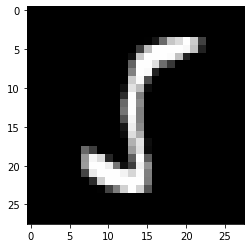

Reconstructed Image utilizing NICE Model:


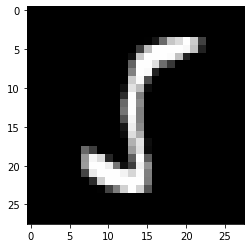

Reconstruction Error: 0.0005856438656337559
Original Image:


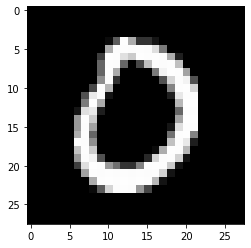

Reconstructed Image utilizing NICE Model:


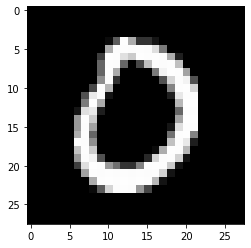

Reconstruction Error: 0.0005973355728201568
Original Image:


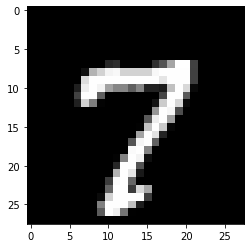

Reconstructed Image utilizing NICE Model:


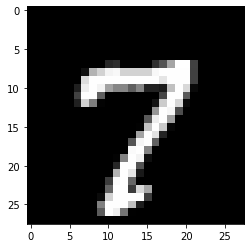

Reconstruction Error: 0.0005845214473083615


In [240]:
for i in range(3):
    plot_sample()